In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.sparse import csc_matrix, csr_matrix

In [2]:
def load_movielens(mean_adjust = 'user'):
    '''Loads movielens set into a Dataframe. Adjusted rating is user by default'''
    path = 'ml-latest-small\\'
    df = pd.read_csv(path + 'ratings.csv')
    movie_xref = pd.read_csv(path + 'movies.csv')
    users = df.groupby('userId').mean()['rating'].reset_index()
    users['user_mean_rating'] = users['rating']
    users['uid'] = users.index
    users.drop('rating',inplace=True,axis=1)
    df = df.merge(users,left_on='userId',right_on='userId')
    movies = df.groupby('movieId').mean()['rating'].reset_index()
    movies['movie_mean_rating'] = movies['rating']
    movies = movies.merge(movie_xref,left_on='movieId',right_on='movieId')
    movies.drop('rating',inplace=True,axis=1)
    movies['mid'] = movies.index
    df = df.merge(movies,left_on='movieId',right_on='movieId')
    if mean_adjust == 'user':
        df['adjusted_rating'] = df['rating'] - df['user_mean_rating']
    elif mean_adjust == 'movie':
        df['adjusted_rating'] = df['rating'] - df['movie_mean_rating']
    return df

def test_sparse(sparse_matrix):
    n = sparse_matrix.nnz
    s = sparse_matrix.shape
    return 1-n/(s[0]*s[1])

In [3]:
df = load_movielens()
users_list = df['uid']
movies_list = df['mid']
ratings_list = df['rating']
df_sparse = csr_matrix((ratings_list,(users_list,movies_list)))

# Naive Bayes

In [6]:
def calculate_priors(df):
    m_ct = df.groupby('mid').count()['uid'].reset_index()
    mr_ct = df.groupby(['mid','rating']).count()['uid'].reset_index()
    total_ct = m_ct.merge(mr_ct,left_on='mid',right_on='mid')
    total_ct['prob'] = total_ct['uid_y']/total_ct['uid_x']
    return total_ct[['mid','rating','prob']]

def calculate_priors_sparse(df_sparse,laplacian = None):
    '''laplacian should be a floating point'''
    '''This takes a sparse matrix which has as columns the set of items to be rated'''
    '''The rows are each one user.'''
    '''Nonzero entries are ratings of items they have rated'''
    
    num_cols = df_sparse.shape[1]
    all_ratings = list(set(df_sparse.data))
    all_ratings = all_ratings
    all_ratings = sorted(all_ratings)
    num_ratings = len(all_ratings)
    ct_df = np.zeros((num_cols,num_ratings))

    for c in range(num_cols):
        #counts the number of unique ratings (per column) and how many times that rating occurred
        unq,cts = np.unique(df_sparse[:,c].toarray(),return_counts=True)
        d = dict(zip(unq, cts))
        d = {k:v for k,v in d.items() if k > 0}
        rating_dict = {rating:0 for rating in all_ratings}
        for k,v in d.items():
            rating_dict[k] = v
        #d = {k:v for k,v in d.items() if k!=0}
        ct_df[c] = [i[1] for i in sorted(rating_dict.items(),key=lambda x: x[0])]
    #This dataframe now has rows which are films, columns which are ratings, and each entry has the number of times
    #which that particular rating occurred for that particular film
    ct_df = pd.DataFrame(ct_df)
    ct_df.columns = all_ratings
    numerator_cols = ct_df.columns
    ct_df['rowsum'] = ct_df.sum(axis=1)

    if laplacian is not None:
        ct_df[numerator_cols] = ct_df[numerator_cols].fillna(0) + laplacian
        ct_df['rowsum'] = ct_df['rowsum'].fillna(0) + laplacian * len(numerator_cols)
    ct_df = ct_df.apply(lambda x: x/x.rowsum,axis=1)
    ct_df = ct_df.drop('rowsum',axis=1)
    ct_df = ct_df.unstack().reset_index()
    ct_df.columns = ['rating','mid','prob']
    return ct_df

#Will need to fix this similarly to the above
def calculate_conditional(df,rating_vs,rating_k,j,k,laplacian = None):
    '''
    df is the sparse dataframe containing the data to be trained/rated
    rating_vs is the rating that we're comparing against for the conditional - 
        P(r_uk | r_uj = v_s), what's the likelihood that we observed rating r_uk for item k (user u) given that
        user u gave item j the rating v_s
    '''
    total_users = df.shape[0]
    df_j = df[:,j]
    #Find set of users who rated item j rating
    users = (df_j == rating_vs).nonzero()[0]
    num_users = len(users)
    #Of those users, how many rated item k the same as the original user?
    df_k = df_sparse[users,k]
    nz = df_k.nonzero()
    nzk = df_k[nz[0]].toarray()
    unq,cts = np.unique(nzk,return_counts=True)
    ct = []

    d = dict(zip(unq, cts))
    d = {k:v for k,v in d.items() if k!=0}
    ct.append(d)
    #This dataframe now has rows which are films, columns which are ratings, and each entry has the number of times
    #which that particular rating occurred for that particular film
    ct_df = pd.DataFrame(ct)
    numerator_cols = ct_df.columns
    ct_df['rowsum'] = ct_df.sum(axis=1)

    if laplacian is not None:
        ct_df[numerator_cols] = ct_df[numerator_cols].fillna(0) + laplacian
        ct_df['rowsum'] = ct_df['rowsum'].fillna(0) + laplacian * total_users
    try:
        retval = (ct_df[rating_vs].values/ct_df['rowsum'].values)[0]
    except:
        retval = 1/total_users
    return retval
    
def calculate_rating(df,user,item,laplacian = None):
    '''
    df: sparse array (csc?) containing the data to be predicted
    user is index of user to look at
    item is item to be rated
    
    for all items that the user rated, we need to see, for each rating possible to use,
    what the likelihood is that user rated item, that rating. In order to do so, we use the formula:
    
    P(r_uj = v_s | Observed ratings of user u) is proportional to P(r_uj = v_s) * PI(P(r_uk | r_uj = v_s) for k in I_u)
    Where I_u is the set of items that user u has rated
    P(r_uj = vs) is called the prior probability, and we'll need to calculate that for each item first
    P(r_uk | r_uj = v_s) is called the conditional probability.
    '''
    
    #priors contains the prior probabilities for all items
    #for a given item, it's the list of all ratings and what ratio, 
    #for each rating for that item, what was the likelihood it occurred
    priors = calculate_priors_sparse(df,laplacian = laplacian)
    vals = list(set(df.data))
    num = 0
    denom = 0
    user_items = df[user,:].nonzero()[1]
    for i in range(len(vals)):
        vs = vals[i]
        try:
            prior = priors.loc[(priors['mid']==item)&(priors['rating']==vs),'prob'].values[0]
        except:
            prior = 0
            continue
        mult = 1
        for k in user_items:
            user_rating = df[user,k]
            conditional = calculate_conditional(df,vs,user_rating,item,k,laplacian = laplacian)
            mult = mult * conditional 
            if np.isnan(conditional or np.isnan(prior)):
                print('vs: %0.3f rating: %0.3f item: %i k: %i')
        num += vs*prior*mult
        denom += prior * mult
    return num/denom

def print_user_movies(df,user):
    movies = df.loc[df['uid']==user,'title']
    print(movies)

In [100]:
test = [
    [1,-1,1,-1,1,-1],
    [1,1,0,-1,-1,-1],
    [0,1,1,-1,-1,0],
    [-1,-1,-1,1,1,1],
    [-1,0,-1,1,1,1]
]
test_array = np.array(test)
test_sparse = csc_matrix(test_array)

In [134]:
p = calculate_priors_sparse(df_sparse,laplacian=0.8)

In [135]:
r = calculate_rating(df_sparse,2,1,laplacian = 0.8)
print(r)

3.98558709162


In [136]:
r = calculate_rating(df_sparse,2,321,laplacian=0.8)
print(r)

4.00000000244


In [137]:
r = calculate_rating(df_sparse,2,595,laplacian=0.8)
print(r)

2.99619678703


In [20]:
r = calculate_rating(df_sparse,580,1,laplacian=0.8)
print(r)

3.66251781122


# Latent Factor Models

In [88]:
def construct_factors(df_sparse,num_factors):
    '''Constructs the num_factors user factors and item factors for the sparse matrix'''
    m = df_sparse.shape[0]
    n = df_sparse.shape[1]
    U = np.random.rand(m,num_factors)
    V = np.random.rand(n,num_factors)
    return U,V

def error(df_sparse,U,V):
    '''Calculates the matrix portion of the error term'''
    d = df_sparse.nonzero()
    rows = d[0].reshape(1,-1).flatten()
    cols = d[1].reshape(1,-1).flatten()
    e = df_sparse[d] - np.matmul(U,V.T)[d]
    e = np.asarray(e).flatten()
    e = csc_matrix((e,(rows,cols)))
    return e

def frobenius_norm(df_sparse,U,V):
    e = error(df_sparse,U,V)
    e = e.power(2)
    return e.sum()

def cost_function(df_sparse,U,V,l):
    '''Calculates the cost function to minimize, l is the regularization term'''
    e = frobenius_norm(df_sparse,U,V)
    usum = np.square(U).sum()
    vsum = np.square(V).sum()
    J = 0.5 * e + (l/2)*usum + (l/2)*vsum
    return J

def update_factors(df_sparse,U,V,l,alpha):
    '''alpha is learning rate, l is regularization parameter'''
    nz = df_sparse.nonzero()
    E = error(df_sparse,U,V)
    U_temp = U*(1-alpha * l) + alpha * (E * V)
    V_temp = V*(1-alpha * l) + alpha * (E.T * U)
    return U_temp,V_temp

def fit(df_sparse,num_factors,learning_rate,regularization_rate):
    U,V = construct_factors(df_sparse,num_factors)
    J = cost_function(df_sparse,U,V,regularization_rate)
    prev = J
    iter_ctr = 0
    while True:
        iter_ctr += 1
        U,V = update_factors(df_sparse,U,V,regularization_rate,learning_rate)
        J = cost_function(df_sparse,U,V,regularization_rate)
        pct_change = J/prev-1
        if abs(pct_change) < 0.001 or iter_ctr > 1000:
            break
        prev = J
    return U,V
    

In [89]:
U,V = fit(df_sparse,10,0.0001,0.8)
pred_rat = np.matmul(U,V.T)

In [81]:
e = error(df_sparse,U,V)

In [82]:
print(df_sparse[0,30])
print(e[0,30])
print(pred_rat[0,30])

2.5
0.0479521599001
2.4520478401


In [83]:
cost_function(df_sparse,U,V,l)

54999.428332574898

In [84]:
e = error(df_sparse,U,V)

# Split into Train-Test Sets

In [4]:
from numpy.random import choice
from scipy.sparse import lil_matrix

def train_test_split(sparse_matrix,pct):
    '''Splits a sparse matrix into two sets - a train set and a test set'''
    nz_coord = list(zip(*sparse_matrix.nonzero()))
    nz_coord_array = np.array(nz_coord)
    num_rand = int(np.floor(len(nz_coord)*(pct/100.0)))
    n = len(nz_coord)
    c = choice(n,size=num_rand,replace=False)
    rows = nz_coord_array[c][:,0]
    cols = nz_coord_array[c][:,1]
    vals = np.array(sparse_matrix[rows,cols]).flatten()
    train = sparse_matrix.copy()
    test = lil_matrix(train.shape)
    test[rows,cols] = vals
    test = test.tocsr()
    train[rows,cols] = 0
    train.eliminate_zeros()
    return train,test

In [6]:
train,test = train_test_split(df_sparse,20)

In [94]:
test

<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 5000 stored elements in Compressed Sparse Row format>

In [95]:
U,V = fit(train,10,0.0001,0.8)
pred_rat = np.matmul(U,V.T)

In [96]:
e = error(test,U,V)

In [97]:
e

<671x9057 sparse matrix of type '<class 'numpy.float64'>'
	with 5000 stored elements in Compressed Sparse Column format>

# Playing With Dimensionality Reduction

In [7]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [8]:
df_sparse

<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 100004 stored elements in Compressed Sparse Row format>

In [ ]:
inertia = []
for i in range(2,51):
    num_clusters = i
    km = MiniBatchKMeans(num_clusters)
    km.fit(df_sparse)
    inertia.append(km.inertia_)

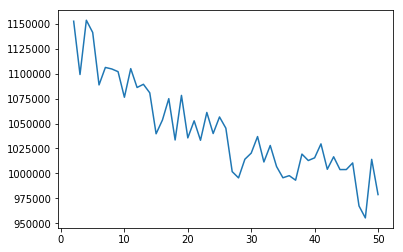

In [11]:
plt.plot(list(range(2,51)),inertia)
plt.show()

In [8]:
num_clusters = 35
km = MiniBatchKMeans(num_clusters)
labels = km.fit_predict(df_sparse)

In [9]:
user_ids = pd.DataFrame(sorted(df['uid'].unique()),columns=['uid'])
user_ids['cluster'] = labels

In [10]:
df = df.merge(user_ids,left_on='uid',right_on='uid')

In [11]:
cluster_list = df['cluster']
movies_list = df['mid']
ratings_list = df['rating']
ratings_list_implicit = [1 for i in ratings_list]
new_sparse = csr_matrix((ratings_list,(cluster_list,movies_list)))

# Cluster Analysis

In [31]:
cluster_uid_ct = df.groupby('cluster').uid.nunique()
#How many of the 35 clusters have only 1 or 2 users?
len(cluster_uid_ct[cluster_uid_ct<=2])
#Wayyyy too many single/two user clusters - lack of density in dataset

29

In [10]:
#What if we train CF and then cluster?

import implicit
factors = 20
regularization = 0.1
iterations = 50
model = implicit.als.AlternatingLeastSquares(factors=factors,regularization=regularization,iterations=iterations)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(df_sparse.T)

user_vecs = model.user_factors
item_vecs = model.item_factors

In [8]:
user_vecs.shape

(671, 20)

In [18]:
inertia = []
for i in range(2,51):
    num_clusters = i
    km = MiniBatchKMeans(num_clusters)
    km.fit(user_vecs)
    inertia.append(km.inertia_)

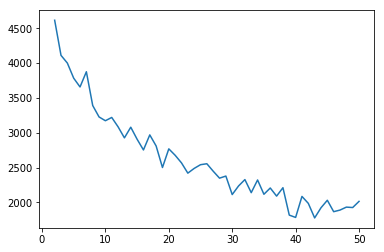

In [10]:
plt.plot(list(range(2,51)),inertia)
plt.show()

In [11]:
num_clusters = 40
km = MiniBatchKMeans(num_clusters)
labels = km.fit_predict(user_vecs)
user_ids = pd.DataFrame(sorted(df['uid'].unique()),columns=['uid'])
user_ids['cluster'] = labels

In [12]:
user_ids.groupby('cluster').uid.nunique()
df = df.merge(user_ids,left_on='uid',right_on='uid')

In [13]:
df = df.join(df['genres'].str.get_dummies())

In [11]:
df.groupby('cluster').agg(['count','mean'])[['rating','Drama']]

rating           Drama          
         count      mean count      mean
cluster                                 
0         2416  3.552566  2416  0.475579
1         3885  3.452381  3885  0.578636
2         1354  3.776219  1354  0.648449
3         1788  3.451902  1788  0.507830
4          266  3.548872   266  0.360902
5         2061  3.870209  2061  0.523047
6          513  3.514620   513  0.391813
7         5868  3.589980  5868  0.427232
8         5036  3.812351  5036  0.445790
9         1281  3.672131  1281  0.434036
10        1988  3.859909  1988  0.309356
12        3362  3.317668  3362  0.423557
13        3638  3.461242  3638  0.413139
14         698  3.628940   698  0.286533
15         306  3.542484   306  0.379085
16        1120  3.705357  1120  0.379464
17        4328  3.752542  4328  0.416590
18        4732  3.453402  4732  0.464920
19        7117  3.000913  7117  0.480399
20        4301  3.830970  4301  0.422692
21         522  3.614943   522  0.498084
22        2253  3.879050  2253  0.626276
23        1827  3.640941  1827  0.511221
24        6849  3.617243  6849  0.464739
25        1043  3.157718  1043  0.518696
26        1226  3.537113  1226  0.405383
27        1434  3.756625  1434  0.550209
28         999  3.427928   999  0.608609
29        3982  3.901808  3982  0.542190
30         560  3.152679   560  0.307143
31        2110  3.530569  2110  0.336493
32         574  3.797909   574  0.292683
33        4135  3.296493  4135  0.363724
34         843  3.499407   843  0.246738
35        6878  3.260904  6878  0.402879
36        2808  3.882123  2808  0.487892
37        2877  3.265728  2877  0.337504
38        2171  3.608475  2171  0.365269
39         855  3.780117   855  0.367251

In [97]:
#Let's look at cluster 5 and see what's going on there
five = df[df['cluster']==5]

In [92]:
unique_genres = list(df['genres'].str.get_dummies().columns[1:])

In [93]:
#They watch Drama a little more, watch action/adventure a little less
m = df.shape[0]
overall_pct = df[unique_genres].sum()/m
m = five.shape[0]
five[unique_genres].sum()/m - overall_pct

Action         0.047633
Adventure      0.056519
Animation      0.000885
Children       0.019264
Comedy        -0.013973
Crime         -0.006527
Documentary   -0.013004
Drama         -0.060809
Fantasy       -0.011045
Film-Noir     -0.007447
Horror        -0.048793
IMAX          -0.028265
Musical        0.004824
Mystery       -0.011688
Romance        0.026674
Sci-Fi        -0.006740
Thriller       0.110588
War           -0.025215
Western       -0.015825
dtype: float64

In [94]:
m = df.shape[0]
df[unique_genres].sum()/m

Action         0.270549
Adventure      0.220161
Animation      0.061698
Children       0.086797
Comedy         0.380245
Crime          0.162653
Documentary    0.015639
Drama          0.447502
Fantasy        0.106566
Film-Noir      0.011400
Horror         0.067897
IMAX           0.031559
Musical        0.047218
Mystery        0.076247
Romance        0.193352
Sci-Fi         0.153644
Thriller       0.252390
War            0.050248
Western        0.019119
dtype: float64

In [104]:
for g in unique_genres:
    print('Genre: %s\t\tAvg_Rating: %0.2f'%(g,df.loc[df[g]==1,'adjusted_rating'].mean()))

Genre: Action		Avg_Rating: -0.09
Genre: Adventure		Avg_Rating: -0.04
Genre: Animation		Avg_Rating: 0.08
Genre: Children		Avg_Rating: -0.07
Genre: Comedy		Avg_Rating: -0.08
Genre: Crime		Avg_Rating: 0.12
Genre: Documentary		Avg_Rating: 0.31
Genre: Drama		Avg_Rating: 0.12
Genre: Fantasy		Avg_Rating: -0.03
Genre: Film-Noir		Avg_Rating: 0.34
Genre: Horror		Avg_Rating: -0.17
Genre: IMAX		Avg_Rating: 0.01
Genre: Musical		Avg_Rating: 0.05
Genre: Mystery		Avg_Rating: 0.11
Genre: Romance		Avg_Rating: 0.01
Genre: Sci-Fi		Avg_Rating: -0.10
Genre: Thriller		Avg_Rating: -0.02
Genre: War		Avg_Rating: 0.22
Genre: Western		Avg_Rating: 0.02


In [103]:
#Compared to average, they like Sci-Fi less than overall adjusted average, as well as Action and Adventure
#Oddly they also like IMAX less than in the overall adjusted average
for g in unique_genres:
    print('Genre: %s\t\tAvg_Rating: %0.2f'%(g,five.loc[five[g]==1,'adjusted_rating'].mean()))

Genre: Action		Avg_Rating: -0.21
Genre: Adventure		Avg_Rating: -0.15
Genre: Animation		Avg_Rating: 0.02
Genre: Children		Avg_Rating: -0.06
Genre: Comedy		Avg_Rating: -0.08
Genre: Crime		Avg_Rating: 0.10
Genre: Documentary		Avg_Rating: 0.30
Genre: Drama		Avg_Rating: 0.10
Genre: Fantasy		Avg_Rating: -0.04
Genre: Film-Noir		Avg_Rating: 0.37
Genre: Horror		Avg_Rating: -0.23
Genre: IMAX		Avg_Rating: -0.18
Genre: Musical		Avg_Rating: 0.04
Genre: Mystery		Avg_Rating: 0.10
Genre: Romance		Avg_Rating: 0.05
Genre: Sci-Fi		Avg_Rating: -0.24
Genre: Thriller		Avg_Rating: -0.06
Genre: War		Avg_Rating: 0.22
Genre: Western		Avg_Rating: 0.03


In [90]:
five.loc[five['IMAX']==1].groupby('title').count()['movieId'].sort_values(ascending=False)

title
Apollo 13 (1995)                                       14
Beauty and the Beast (1991)                            13
Lion King, The (1994)                                  12
Harry Potter and the Prisoner of Azkaban (2004)         4
Star Wars: Episode II - Attack of the Clones (2002)     4
Spider-Man 2 (2004)                                     4
Matrix Reloaded, The (2003)                             4
Alice in Wonderland (2010)                              3
Avatar (2009)                                           3
Fantasia 2000 (1999)                                    2
Harry Potter and the Goblet of Fire (2005)              2
Inception (2010)                                        2
300 (2007)                                              2
Everest (1998)                                          2
Batman Begins (2005)                                    2
Toy Story 3 (2010)                                      2
Charlie and the Chocolate Factory (2005)                2
Dark Kni

In [56]:
five.loc[five['Action']==1,'rating'].mean()

3.569246972090574

In [79]:
five.iloc[0]

userId                                              99
movieId                                           1029
rating                                               3
timestamp                                    938587916
user_mean_rating                               3.43085
uid                                                 98
movie_mean_rating                              3.70238
title                                     Dumbo (1941)
genres                Animation|Children|Drama|Musical
mid                                                833
adjusted_rating                              -0.430851
cluster                                              5
(no genres listed)                                   0
Action                                               0
Adventure                                            0
Animation                                            1
Children                                             1
Comedy                                               0
Crime     

In [59]:
m = five.shape[0]
five[unique_genres].mean()

Action         0.184962
Adventure      0.169670
Animation      0.051622
Children       0.073244
Comedy         0.352294
Crime          0.162267
Documentary    0.022791
Drama          0.537255
Fantasy        0.085030
Film-Noir      0.025811
Horror         0.055907
IMAX           0.009253
Musical        0.063115
Mystery        0.089413
Romance        0.212818
Sci-Fi         0.126619
Thriller       0.210383
War            0.061654
Western        0.022986
dtype: float64

In [74]:
five.groupby('title').count()['movieId'].sort_values(ascending=False)

title
Fargo (1996)                                                                      31
American Beauty (1999)                                                            30
Star Wars: Episode IV - A New Hope (1977)                                         29
Schindler's List (1993)                                                           28
L.A. Confidential (1997)                                                          28
Silence of the Lambs, The (1991)                                                  27
E.T. the Extra-Terrestrial (1982)                                                 27
Saving Private Ryan (1998)                                                        27
Pulp Fiction (1994)                                                               27
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    26
Star Wars: Episode V - The Empire Strikes Back (1980)                             26
Back to the Future (1985)                                  

# Using "Implicit" Library

In [80]:
cluster_list = df['cluster']
movies_list = df['mid']
ratings_list = df['rating']
ratings_list_implicit = [1 for i in ratings_list]
new_sparse = csr_matrix((ratings_list_implicit,(cluster_list,movies_list)))
#1 or 0 each value
new_sparse = new_sparse.sign()

In [81]:
train,test = train_test_split(new_sparse,20)

In [82]:
new_sparse.todense()

matrix([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ..., 
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [17]:
def user_rated_movies(df,sparse_matrix,uid,cluster=False):
    '''uid can be cluster or user id'''
    mid = sparse_matrix[uid].nonzero()[1]
    if cluster:
        user_string = 'cluster'
    else:
        user_string = 'uid'    
    df_rows = df.loc[(df[user_string]==uid)&(df['mid'].isin(train[uid].nonzero()[1])),:]
    gb = df_rows.groupby('title').agg(['count','mean'])['user_mean_rating']
    gb = gb.sort_values(by='count',ascending=False)
    print(gb[:10])
    
def train_model(df,train):
    factors = 20
    regularization = 0.1
    iterations = 50
    model = implicit.als.AlternatingLeastSquares(factors=factors,regularization=regularization,iterations=iterations)

    # train the model on a sparse matrix of item/user/confidence weights
    model.fit(train.T)
    return model
    
def recommend_movies(df,model,train,test,uid,cluster=False):
    '''Predict what a user (or cluster) would like based on trained model'''
    r = model.recommend(uid,test.T)
    user_rated_movies(df,train,uid,cluster)
    rec_mids = [i[0] for i in r]
    movies = df[['mid','title']].drop_duplicates().reset_index().drop('index',axis=1)
    print(movies.loc[movies['mid'].isin(rec_mids),:])

In [53]:
#Those recommendations look pretty bad - what did I do wrong?
m = train_model(df,train)
recommend_movies(df,m,train,test,5,True)

                                                    count      mean
title                                                              
Star Wars: Episode IV - A New Hope (1977)              22  3.766792
Lord of the Rings: The Fellowship of the Ring, ...     21  3.772877
Star Wars: Episode V - The Empire Strikes Back ...     20  3.767122
Forrest Gump (1994)                                    20  3.841776
Shawshank Redemption, The (1994)                       19  3.838621
Shrek (2001)                                           19  3.718777
Pulp Fiction (1994)                                    18  3.753216
Matrix, The (1999)                                     17  3.712525
Sixth Sense, The (1999)                                17  3.791848
Monsters, Inc. (2001)                                  16  3.771808
       mid                                             title
16    1815                                       Antz (1998)
40     617                                    Twister (1996)
3

In [46]:
#Below code taken from https://jessesw.com/Rec-System/
from sklearn import metrics
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    print(float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc)))
    return store_auc, popularity_auc
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [83]:
m = train_model(df,train)

In [40]:
recommend_movies(df,m,train,test,3,True)

                                                    count      mean
title                                                              
Forrest Gump (1994)                                     9  3.463514
Pirates of the Caribbean: The Curse of the Blac...      9  3.463514
Beautiful Mind, A (2001)                                8  3.503090
Matrix, The (1999)                                      8  3.440850
Sin City (2005)                                         8  3.503090
Lord of the Rings: The Two Towers, The (2002)           8  3.433490
Independence Day (a.k.a. ID4) (1996)                    7  3.480114
Jurassic Park (1993)                                    7  3.480114
Shrek (2001)                                            7  3.480114
Rock, The (1996)                                        7  3.403299
       mid                                              title
106    472                            Schindler's List (1993)
107    642                               Trainspotting (1996

In [41]:
altered_users = np.unique(test.nonzero()[0])

In [42]:
user_vecs = csr_matrix(m.user_factors)
item_vecs = csr_matrix(m.item_factors)

In [47]:
s,p = calc_mean_auc(train,altered_users,[user_vecs,item_vecs.T],test)

0.726 0.892


In [55]:
s[14]

0.94362745098039214

In [65]:
recommend_movies(df,m,train,test,14,True)

                                                    count      mean
title                                                              
Star Wars: Episode VI - Return of the Jedi (1983)       6  3.698346
Star Wars: Episode I - The Phantom Menace (1999)        6  3.531905
Abyss, The (1989)                                       5  3.443277
20,000 Leagues Under the Sea (1954)                     4  3.537141
E.T. the Extra-Terrestrial (1982)                       4  3.600298
Star Trek II: The Wrath of Khan (1982)                  4  3.686382
Star Wars: Episode V - The Empire Strikes Back ...      4  3.806377
Alien (1979)                                            4  3.533720
African Queen, The (1951)                               3  3.524325
Star Trek: Generations (1994)                           3  3.741836
       mid                                          title
41     954                     Princess Bride, The (1987)
69    1112  Star Trek VI: The Undiscovered Country (1991)
71    1116

In [58]:
df.loc[df['title']=='Abyss, The (1989)',:]

,userId,movieId,rating,timestamp,user_mean_rating,uid,movie_mean_rating,title,genres,mid,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
500,73,1127,4.0,1262660448,3.374224,72,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
2510,111,1127,4.0,1097429377,3.511730,110,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
4563,311,1127,3.0,898008186,3.006379,310,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
5994,452,1127,3.0,976424722,3.189179,451,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
8066,461,1127,2.5,1091958692,2.839080,460,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
8755,468,1127,3.0,1296190072,2.965918,467,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
10450,525,1127,5.0,1024929806,3.659420,524,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
11261,607,1127,4.5,1113406159,3.653396,606,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
11938,19,1127,3.0,855195373,3.534279,18,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0
14148,213,1127,2.5,1462638456,2.660440,212,3.612676,"Abyss, The (1989)",Action|Adventure|Sci-Fi|Thriller,904,...,0,0,0,0,0,0,1,1,0,0


In [19]:
user_vecs = m.user_factors
item_vecs = m.item_factors

In [135]:
np.min(item_vecs.dot(user_vecs.T).T)

-0.029825978

# Discounted Cumulative Gain

In [ ]:
#More help here: http://fastml.com/evaluating-recommender-systems/

In [89]:
def dcg(user,user_item_matrix,model):
    r = model.recommend(user,user_item_matrix.T,N=100)
    recids = [i[0] for i in r]
    dcg_val = 0
    ctr = 1
    for rec in recids:
        g = user_item_matrix[user,rec]
        num = 2**g - 1
        denom = np.log2(ctr + 1)
        dcg_val += num/denom
        ctr += 1
    return dcg_val

def ideal_dcg(user,user_item_matrix):
    ideal_100 = user_item_matrix[user].todense()
    ideal_100 = np.asarray(ideal_100).reshape(-1)
    ideal_100_sorted = (-ideal_100).argsort()[:100]
    
    dcg_val = 0
    ctr = 1
    for movie in ideal_100_sorted:
        g = user_item_matrix[user,movie]
        num = 2**g - 1
        denom = np.log2(ctr + 1)
        dcg_val += num/denom
        ctr += 1
    return dcg_val

def normalized_dcg(user,user_item_matrix,model):
    d = dcg(user,user_item_matrix,model)
    i = ideal_dcg(user,user_item_matrix)
    print('%0.3f'%(d/i))
    return d,i

def arhr(user,user_item_matrix,model):
    '''Average recpirocal hit rank'''
    r = model.recommend(user,user_item_matrix.T,N=100)
    recids = [i[0] for i in r]
    dcg_val = 0
    ctr = 1
    for rec in recids:
        g = user_item_matrix[user,rec]
        num = g
        denom = ctr
        dcg_val += num/denom
        ctr += 1
    print('%0.3f'%(dcg_val))
    return dcg_val

def mrr(user_item_matrix,model):
    m = user_item_matrix.shape[0]
    mrr_sum = 0
    for user in range(m):
        mrr_sum += arhr(user,user_item_matrix,model)
    print('%0.3f'%(mrr_sum/m))
    return mrr_sum/m

In [90]:
test_user = 14
test_item = 1127
sparse_matrix = new_sparse
#d = dcg(test_user,sparse_matrix,model)
#i = ideal_dcg(test_user,sparse_matrix)
for i in range(sparse_matrix.shape[0]):
    dcg_val,idcg_val = normalized_dcg(i,sparse_matrix,model)
    arhr(i,sparse_matrix,model)

mrr(sparse_matrix,model)
    
#Well this isn't right - ideal should in every case be better than the dcg of the recommendations

0.500
2.556
0.640
4.307
0.946
5.088
0.992
5.170
1.000
5.187
1.000
5.187
0.619
4.229
0.413
1.945
0.967
5.110
0.574
3.194
0.804
4.718
0.639
3.710
0.985
5.163
0.090
0.295
0.430
2.142
1.000
5.187
0.629
4.061
0.976
5.139
0.859
4.608
0.900
4.948
0.855
4.869
0.637
4.087
0.557
2.385
0.515
2.250
0.986
5.167
1.000
5.187
0.974
5.115
0.742
4.425
0.785
4.188
0.971
5.065
0.466
2.224
0.881
4.946
0.844
4.618
0.824
4.638
0.656
2.835
0.827
4.775
0.778
4.572
0.656
4.059
0.379
2.308
0.969
5.132
2.556
4.307
5.088
5.170
5.187
5.187
4.229
1.945
5.110
3.194
4.718
3.710
5.163
0.295
2.142
5.187
4.061
5.139
4.608
4.948
4.869
4.087
2.385
2.250
5.167
5.187
5.115
4.425
4.188
5.065
2.224
4.946
4.618
4.638
2.835
4.775
4.572
4.059
2.308
5.132
4.120


4.1196772214816191

In [62]:
test_user = 39
user_item_matrix = sparse_matrix
r = model.recommend(test_user,user_item_matrix.T,N=100)
recids = [i[0] for i in r]
dcg_val = 0
ctr = 1
for rec in recids:
        g = user_item_matrix[test_user,rec]
        #print('Position: %i Movie %i Score %0.3f'%(ctr,rec,g))
        num = 2**g - 1
        denom = np.log2(ctr + 1)
        dcg_val += num/denom
        ctr += 1
dcg = dcg_val
print(dcg_val)

ideal_100 = user_item_matrix[test_user].todense()
ideal_100 = np.asarray(ideal_100).reshape(-1)
ideal_100_sorted = (-ideal_100).argsort()[:100]

dcg_val = 0
ctr = 1
for movie in ideal_100_sorted:
    g = user_item_matrix[test_user,movie]
    num = 2**g - 1
    denom = np.log2(ctr + 1)
    dcg_val += num/denom
    ctr += 1
ndcg = dcg_val
print(dcg/ndcg)

20.2944655298
0.969233704071


In [47]:
user_item_matrix[test_user,recids]

<1x100 sparse matrix of type '<class 'numpy.int32'>'
	with 96 stored elements in Compressed Sparse Row format>

In [41]:
user_item_matrix[39]

<1x9066 sparse matrix of type '<class 'numpy.int32'>'
	with 964 stored elements in Compressed Sparse Row format>

In [162]:
dcg(test_user,sparse_matrix,model)

8.2393120886598386

In [154]:
ideal_dcg(test_user,sparse_matrix)

60.683283253009627

In [125]:
sparse_matrix[test_user,ideal_100]

<1x9066 sparse matrix of type '<class 'numpy.int32'>'
	with 520 stored elements in Compressed Sparse Row format>

In [111]:
dcg = 0
ctr = 1
for m in mids:
    #g represents gain
    g = sparse_matrix[test_user,m]
    if g > 0:
        num = g
        denom = np.log2(ctr + 1)
        dcg += num/denom
    ctr += 1

In [112]:
dcg

8.2393120886598386

In [109]:
user_top = sparse_matrix[test_user,mids].todense()
user_top = user_top[user_top > 0]

In [110]:
user_top

matrix([[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1,
         1, 2, 6, 2, 2, 1]], dtype=int32)

# Maybe I'll try to use Surprise next?

In [ ]:
#http://surpriselib.com/